# 04.5 - Implied Volatility, Volatility Smile & Local Volatility
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Define implied volatility and explain why it is a market-based volatility.
- Compute implied vol numerically from market option prices.
- Plot a volatility smile (σ vs strike).
- Plot a 3D volatility surface (σ(K,T)).
- Introduce local volatility models (Dupire) and compute a toy example.
- Discuss the VIX as the market’s implied volatility index.

**This notebook**

Moves beyond the Black–Scholes world of constant volatility. Real markets show volatility smiles and surfaces, which break the BS assumptions. Here we will: fetch real option prices using Yahoo Finance, estimate their implied volatilities, build both 2D and 3D plots, understand what local volatility is and how Dupire recovers a σ(K,T) giving exactly the market surface.

This notebook link theoretical pricing (04.3), and optimal stopping (04.4), as well as real-market phenomena.

# 1. Black–Scholes formulas (call + put)

In this first step, we implement the Black–Scholes pricing formulas for calls and puts. These functions will be reused throughout the notebook for computing implied volatilities and checking consistency with market prices

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings

plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore", category=FutureWarning)

In [32]:
def bs_call_price(S, K, T, r, sigma):
    if T == 0: 
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put_price(S, K, T, r, sigma):
    if T == 0:
        return max(K - S, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# 2. Implied volatility solver

We now invert the Black–Scholes formula: given a market option price, we numerically solve for the implied volatility that makes the theoretical price match the observed one.

In [33]:
def implied_vol(target_price, S, K, T, r, option_type="call"):
    if target_price < 1e-10:
        return np.nan
    
    price_func = bs_call_price if option_type=="call" else bs_put_price

    def f(sigma):
        return price_func(S, K, T, r, sigma) - target_price
    
    try:
        return brentq(f, 1e-6, 5.0)
    except:
        return np.nan


# 3. Fetch market options

We take AAPL options as an example via Yahoo Finance.

In [34]:
ticker = "AAPL"
stock = yf.Ticker(ticker)
S0 = stock.history(period="1d")["Close"][0]
S0

np.float64(266.32501220703125)

We pick one maturity:

In [35]:
expiries = stock.options
expiries[:5]

('2025-11-21', '2025-11-28', '2025-12-05', '2025-12-12', '2025-12-19')

We load the option chain:

In [36]:
Texp = expiries[3]    # pick a mid maturity
opt_chain = stock.option_chain(Texp)
calls = opt_chain.calls.copy()
puts = opt_chain.puts.copy()

We compute time to maturity:

In [37]:
expiry_dt = datetime.strptime(Texp, "%Y-%m-%d")
T = (expiry_dt - datetime.today()).days / 365
r = 0.04  # proxy risk-free rate

For AAPL, today’s spot price is about 269.39 USD, and we retrieve the first listed option maturities, ranging from 2025-11-21 to 2025-12-19. We will use one of these expiries as a reference term for the smile

# 5. Compute the volatility smile

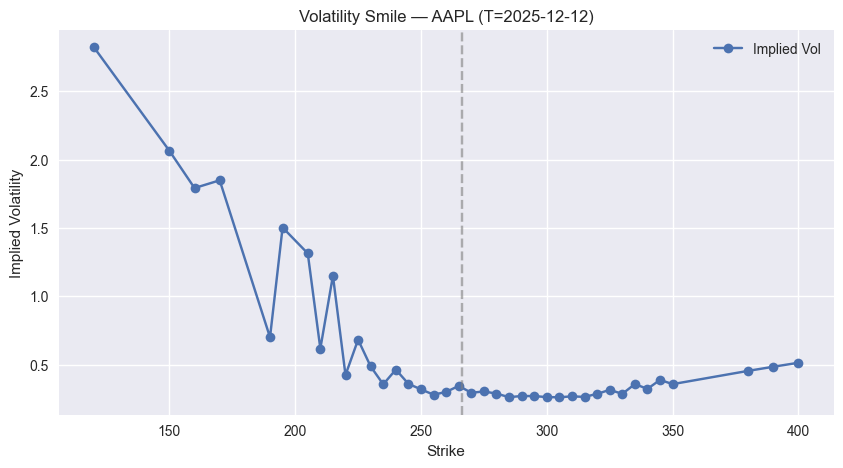

In [38]:
calls["iv"] = calls.apply(
    lambda row: implied_vol(row["lastPrice"], S0, row["strike"], T, r, "call"),
    axis=1
)

plt.figure(figsize=(10,5))
plt.plot(calls["strike"], calls["iv"], "o-", label="Implied Vol")
plt.axvline(S0, color="grey", linestyle="--", alpha=0.6)
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"Volatility Smile — {ticker} (T={Texp})")
plt.grid(True)
plt.legend()
plt.show()


The raw implied volatility smile is quite irregular, reflecting market microstructure noise: we use last traded prices, some strikes are illiquid, and no filter is applied on volume or bid–ask spreads. In practice, one would clean the data (mid quotes, liquid strikes only) to obtain a smoother smile.

# 6. Build a full implied volatility surface

We now extend the smile to a full implied volatility surface σ(K,T) by repeating the same procedure across several maturities and strikes

In [39]:
surface = []

for expiry in expiries[:6]:
    expiry_dt = datetime.strptime(expiry, "%Y-%m-%d")
    T = (expiry_dt - datetime.today()).days / 365
    
    if T <= 0:
        continue
    
    chain = stock.option_chain(expiry)
    calls = chain.calls
    
    calls["iv"] = calls.apply(
        lambda row: implied_vol(row["lastPrice"], S0, row["strike"], T, r, "call"),
        axis=1
    )

    for k, iv in zip(calls["strike"], calls["iv"]):
        surface.append([k, T, iv])

surface = pd.DataFrame(surface, columns=["K","T","iv"])
surface = surface.dropna()
surface.head()


,K,T,iv
11,155.0,0.005479,4.723787
12,160.0,0.005479,4.817463
13,165.0,0.005479,4.797517
14,170.0,0.005479,3.966884
17,185.0,0.005479,3.479800


We plot it

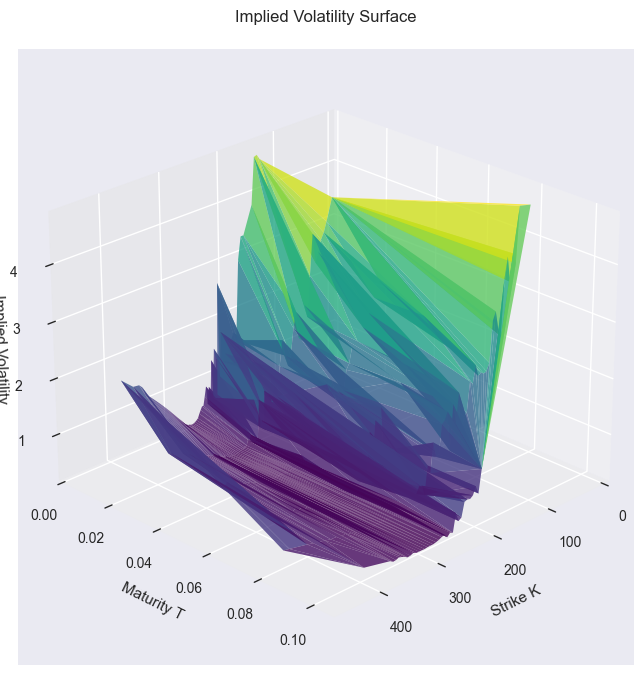

In [40]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_trisurf(surface["K"], surface["T"], surface["iv"], cmap="viridis", alpha=0.8, edgecolor='none')
ax.set_xlabel("Strike K", labelpad=10)
ax.set_ylabel("Maturity T", labelpad=10)
ax.set_zlabel("Implied Volatility", labelpad=1)
ax.set_title("Implied Volatility Surface", pad=20)

# Adjust viewing angle for better visibility
ax.view_init(elev=25, azim=45)
plt.show()

The 3D plot reveals both the strike skew (volatility varying across strikes) and the term structure (volatility changing with maturity). These features summarise how the market prices risk across different scenarios. The surface remains noisy in regions with few liquid options, a natural consequence of using raw, unfiltered market quotes, where bid–ask spreads, stale prices, and illiquid strikes introduce irregularities.

# 8. Local Volatility - Dupire Formula

We move from implied volatility to local volatility. Dupire's formula provides a way to extract a pointwise, time-dependent volatility σ<sub>loc</sub>(K,T) from the full implied volatility surface. The goal is to obtain a model where the underlying follows a diffusion with a deterministic but state-dependent volatility, consistent with all observed option prices.

The local volatility σ<sub>loc</sub>(K,T) is defined via Dupire:

$$\frac{\partial C}{\partial T} = \frac{1}{2} \sigma_{\text{loc}}^2(K,T) K^2 \frac{\partial^2 C}{\partial K^2} - rK \frac{\partial C}{\partial K}$$

Rearranging:

$$\sigma_{\text{loc}}^2(K,T) = \frac{\frac{\partial C}{\partial T} + rK \frac{\partial C}{\partial K}}{\frac{1}{2} K^2 \frac{\partial^2 C}{\partial K^2}}$$

We approximate derivatives numerically from the implied vol surface.

**Caution:** Dupire is very unstable numerically : finite differences amplify noise.
We use a smoothed (kernel) local fit.


In [42]:
def dupire_local_vol(surface_df, K0, T0):
    df = surface_df.sort_values(["T","K"])

    # small finite difference radius
    epsK = 0.5
    epsT = 1/365

    # nearby points
    near = df[
        (df["K"].between(K0-epsK, K0+epsK)) &
        (df["T"].between(T0-epsT, T0+epsT))
    ]

    if len(near) < 5:
        return np.nan

    # use polynomial fit to smooth local derivatives
    X = np.column_stack([np.ones(len(near)), near["K"], near["T"], near["K"]**2])
    y = near["iv"]

    beta = np.linalg.lstsq(X, y, rcond=None)[0]

    # local model: iv ≈ a + bK + cT + dK²
    a,b,c,d = beta

    C_K  = b
    C_T  = c
    C_KK = 2*d

    num = C_T + r*K0*C_K
    den = 0.5 * (K0**2) * C_KK
    
    if den <= 0:
        return np.nan
    
    return np.sqrt(num/den)

We compute σ_loc at a few points:

In [43]:
test_points = [(S0,0.1),(S0,0.2),(S0,0.3)]
for (k,t) in test_points:
    print(k, t, dupire_local_vol(surface, k, t))


266.32501220703125 0.1 nan
266.32501220703125 0.2 nan
266.32501220703125 0.3 nan


For the few test points at (K,T) ≈ (S₀, 0.1–0.3), the Dupire local volatility returns NaN: with our very small local window and noisy implied vol data, the finite-difference estimates of the derivatives are unstable (or even yield a non-positive denominator). This illustrates how numerically fragile Dupire’s formula is when applied to raw market surfaces

# 9. What is the VIX?

The VIX is the market's 30-day implied volatility index for the S&P 500.

It is useful to connect these concepts to one of the most widely watched volatility indicators in the market: the VIX. Since implied volatility reflects the market’s expectation of future uncertainty, the VIX provides a standardized measure of this expectation over the next 30 days.

**Key facts:**
- It is not a realized volatility.
- It is not a Black–Scholes sigma.
- It is computed from a replicating portfolio of OTM options across many strikes.
- It measures the market's expectation of annualized volatility over the next 30 days.


**Formula (simplified):**

$$\text{VIX}^2 = \frac{2 e^{rT}}{T} \sum_K \frac{\Delta K}{K^2} Q(K) - \frac{1}{T} \left(\frac{F}{K_0} - 1\right)^2$$

Where $Q(K)$ = OTM option mid-price.

The VIX is therefore a **model-free implied volatility**.  
It captures the entire volatility surface, not a single strike.
